### Inicializaciones

In [31]:
#!pip install gym
#!pip install pygame

In [32]:
import gym
import numpy as np
import time

### Funciones auxiliares

In [33]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

In [34]:
def get_learning_rate(t, min_rate=0.01):
    return max(min_rate, min(1.0, 1.0 - np.log10((t+1)/25)))

In [35]:
def get_epsilon(t, min_epsilon=0.1):
    return max(min_epsilon, min(1, 1.0 - np.log10((t+1)/25)))

In [36]:
def q_learning(state, Q, episode):   
    done = False
    gamma = 0.999
    while not done:
        alpha = get_learning_rate(episode)
        epsilon = get_epsilon(episode)
        action = epsilon_greedy_policy(state, Q, epsilon)
        obs, reward, done, info, _ = env.step(action)
        current_Q_value = Q[state][action]
        discrete_obs = get_state(obs)
        Q[state][action] = current_Q_value + alpha*(reward + gamma*np.max(Q[discrete_obs][:]) - current_Q_value)
        state = discrete_obs

In [37]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

### Discretizacion de variables de la observación

Como la posicion del carrito y su aceleracion no son tan relevantes como la posicion de la barra y su velocidad, se discretizan utilizando una menor cantidad de contenedores de mayor tamaño Por otro lado, tanto la aceleración angular como el ángulo del poste son las variables de mayor importancia, son los que van a variar con una mayor velocidad. Por lo tanto, se discretizan con una mayor cantidad de contenedores de menor tamaño.

In [38]:
import sys
cart_position_bins, cart_pos_step = np.linspace(-2.4, 2.4, 3, retstep=True)
cart_acc_bins, cart_acc_step = np.linspace(-100, 100, 3, retstep=True)
pole_angle_bins, pole_angle_step = np.linspace(-.2095,.2095, 7, retstep=True)
angular_acc_bins, angular_acc_step = np.linspace(-1000, 1000, 5, retstep=True)
print("cart_pos_step: ", cart_pos_step)
print("cart_acc_step: ", cart_acc_step)
print("pole_angle_step: ", pole_angle_step)
print("angular_acc_step: ", angular_acc_step)

cart_pos_step:  2.4
cart_acc_step:  100.0
pole_angle_step:  0.06983333333333333
angular_acc_step:  500.0


In [39]:
def get_state(obs):
    cart_pos = np.digitize(obs[0], cart_position_bins)
    cart_acc = np.digitize(obs[1], cart_acc_bins)
    pole_ang = np.digitize(obs[2], pole_angle_bins)
    ang_acc = np.digitize(obs[3], angular_acc_bins)
    state = tuple([cart_pos, cart_acc, pole_ang, ang_acc])
    return state

In [40]:
state = get_state(np.array([-1.4, 0.11, -0.100, 200]))
state

(1, 2, 2, 3)

### Inicialización de Q

In [41]:
position_bins_count = cart_position_bins.size + 1
acc_bins_count = cart_acc_bins.size + 1
angle_bins_count = pole_angle_bins.size + 1
angular_acc_bins_count = angular_acc_bins.size + 1
print("Valid cart position bins: 0 - ", position_bins_count - 1)
print("Valid cart acceleration bins: 0 - ", acc_bins_count - 1)
print("Valid pole angle bins: 0 - ", angle_bins_count - 1)
print("Valid pole acceleration bins: 0 - ", angular_acc_bins_count - 1)
Q = np.random.random((position_bins_count,acc_bins_count,angle_bins_count,angular_acc_bins_count,2))
Q.shape

Valid cart position bins: 0 -  3
Valid cart acceleration bins: 0 -  3
Valid pole angle bins: 0 -  7
Valid pole acceleration bins: 0 -  5


(4, 4, 8, 6, 2)

### Entrenamiento

Para el entrenamiento se consideraron distintos casos, en un principio se opto por dejar fijo tanto alpha como epsilon, y aumentar el numero de episodios para ver si mejoraban los resultados, lo cual no sucedio y los resultados oscilaban entre 10 y 40. Al probar con 100000 episodios llevo una cantidad demasiado grande te tiempo por lo que tuvimos que cortarlo a las 3 horas, se pudo observar que funcionaba correctamente cuando ejecutamos la policy optima, pero VSCode dejo de funcionar correctamente, en vista de eso y que tomo una cantidad demasiado grande de tiempo, se opto por disminuir la cantidad de episodios a un numero razonable, y hacer variar el resto de hiperparametros.
Al observar la simulacion unas cuantas veces pudimos notar que genarlmente perdia porque el angulo del palo superaba el limite, y muy pocas veces era porque se iba de rango en el eje X, por esto mismo se opto por usar contenedores más pequeños para los datos menos relevantes, y aumentar, dentro de lo razonable, los contenedores para el angulo y la velocidad angular, para que el agente pudiera aprender a mantener el palo en el centro del carrito.
Comenzamos recortando la cantidad de episodios a 125 y vimos resultados en el entorno de los 20, luego a 250 y aqui oscilaban entre 30 y 70, luego al aumentar a 500 vimos que estaba en el entorno de los 200, luego a 1000 y vimos que bajaba a 75, y luego a 2000 que volvia a 200, pudimos observar que generalemtne parecia converger cerca de los 900, pero luego al llegar a los 1000 empezaba nuevamente a oscilar rapidamente, por lo que se podria concluir que habia un minimo local en ese punto, y al continuar aumentando la cantidad de episodios se observaba el mismo comportamiento en el entorno de los 1700 y 1800, por lo que se opto por dejar la cantidad de episodios en 1750 y esto nos llevo a conseguir un resultado de 500 en promedio que era lo esperado.

In [104]:
env = gym.make('CartPole-v1', new_step_api=True)
done = False
max_episodes = 999
for i in range(max_episodes):
    if i % 100 == 0 or i == max_episodes - 1:
        print('episode: ', i)
    obs = env.reset(seed = i)
    q_learning(get_state(obs), Q, i)
env.close()

episode:  0
episode:  100
episode:  200
episode:  300
episode:  400
episode:  500
episode:  600
episode:  700
episode:  800
episode:  900
episode:  998


### Ejecución con la policy óptima

El resultado esperado de ejecutar la policy optima obtenida es 500 en promedio en 100 corridas continuas, ya que es el máximo de pasos que se puede dar en el entorno, este final se marca en la variable truncation.

In [108]:
time.sleep(1)
env = gym.make('CartPole-v1', new_step_api=True)
tries = 100
rewards = np.zeros(tries)
print("Playing optimal policy")
for i in range(tries):
    episode_reward= 0
    obs = env.reset(seed = i)
    done = False
    while not done:
        state = get_state(obs)
        action = optimal_policy(state, Q)
        obs, reward, termination, truncation, info = env.step(action)
        done = termination or truncation
        episode_reward += reward
    rewards[i] = episode_reward
env.close()
print("Average reward: ", np.mean(rewards))

Playing optimal policy
Average reward:  499.22


In [106]:
def plot(x,y, x_text, y_text, title):
    import matplotlib.pyplot as plt
    plt.title(title)
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    plt.plot(x, y, color ="green", linewidth = 4)
    plt.show()

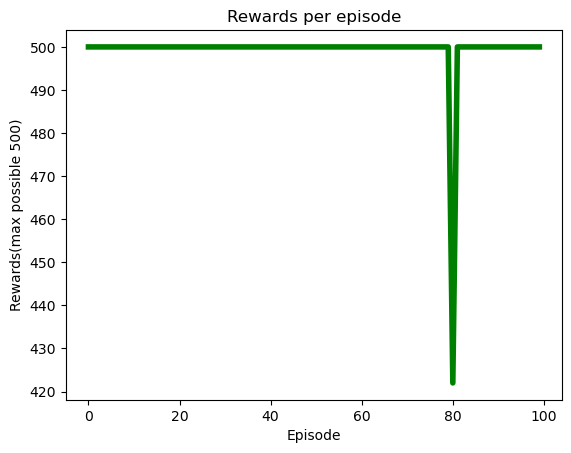

In [107]:

plot(range(tries), rewards, "Episode", "Rewards(max possible 500)", "Rewards per episode")